In [244]:
import torch
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import griddata

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

import os
import re

os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

## Feed Forward Neural Network

In [245]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Heat Equation definition for the NN

In [246]:
def DE(self,x,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([x,t,pr], dim=1))
    
    u_x = torch.autograd.grad(
        u, x, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x, 
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    
    f = u_t + u*u_x - pr*u_xx
    return f

In [247]:
DNN.DE = DE

In [248]:
def samples_space(size,maxl):
    t_f_train = lhs(2, size)*maxl
    t_f_train[:,0] = t_f_train[:,0]*(2)-1
    t_f_train[:,1] = t_f_train[:,1]*(0.5)
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [249]:
def data_pde(size,maxl,minp,maxp):

    t, param = samples_space(size,maxl),samples_param(minp,maxp,(size,1))

    X_u_train = torch.from_numpy(np.concatenate((t.reshape(-1,2),param),axis=1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))

    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

In [250]:
def train(pinn,loss,optimizer,epochs, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
     data_set = np.zeros((epochs*sample_size,3))
     
     print("Starting Training")
     
     for i in range(epochs):
        xy, param =samples_space(sample_size,bound_limit),samples_param(minval_param,maxval_param,(sample_size,1))
        data_set[i*sample_size: (i+1)*sample_size,:] = np.hstack((xy,param))
        
        x,y, param =  torch.tensor(xy[:,0]).float().to(device),torch.tensor(xy[:,1]).float().to(device),torch.tensor(param).float().to(device) 
        
        x,y, param = Variable(x,requires_grad=True).reshape(-1,1),Variable(y,requires_grad=True).reshape(-1,1),Variable(param,requires_grad=True)
        
        for _ in range(15):
                
                optimizer.zero_grad()

                bc_x_pred,bc_pred = pinn(torch.cat([torch.ones_like(x).float()*(-1),y, param], dim=1)), pinn(torch.cat([torch.ones_like(x).float(),y, param], dim=1))
                f_pred,ic_pred = pinn.DE(x,y,param),pinn(torch.cat([x,torch.zeros_like(x).float(), param], dim=1))

                loss_u_ic,loss_u_bc = loss(bc_x_pred,torch.zeros_like(x)),loss(bc_pred,torch.zeros_like(x))

                loss_f, loss_u_ic_x= loss(f_pred,torch.zeros_like(x)),  loss(ic_pred,(-torch.sin(torch.pi*x)))

                Loss =  loss_f + loss_u_ic + loss_u_bc + loss_u_ic_x

                if epochs % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e,Loss_ini: %.5e' % (i, Loss.item(),loss_u_ic.item(),loss_u_bc.item(), loss_f.item(), loss_u_ic_x.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
     return data_set

In [251]:
def train_2(pinn,loss,optimizer, sample_size = 100, bound_limit = 1,minval_param = 0.2,maxval_param = 2):
    
    print("Starting Training")

    xy, param =samples_space(sample_size,bound_limit),samples_param(minval_param,maxval_param,(sample_size,1))
    
    x,y, param =  torch.tensor(xy[:,0]).float().to(device),torch.tensor(xy[:,1]).float().to(device),torch.tensor(param).float().to(device) 
    
    x,y, param = Variable(x,requires_grad=True).reshape(-1,1),Variable(y,requires_grad=True).reshape(-1,1),Variable(param,requires_grad=True)


    def loss_func_train():
        
        optimizer.zero_grad()
        
        bc_x_pred,bc_pred = pinn(torch.cat([torch.ones_like(x).float()*(-1),y, param], dim=1)), pinn(torch.cat([torch.ones_like(x).float(),y, param], dim=1))
        f_pred,ic_pred = pinn.DE(x,y,param),pinn(torch.cat([x,torch.zeros_like(x).float(), param], dim=1))

        loss_u_ic,loss_u_bc = loss(bc_x_pred,torch.zeros_like(x)),loss(bc_pred,torch.zeros_like(x))

        loss_f, loss_u_ic_x= loss(f_pred,torch.zeros_like(x)), loss(ic_pred,(-torch.sin(torch.pi*x)))

        Loss =  loss_f + loss_u_ic + loss_u_bc + loss_u_ic_x 

        print('Loss: %.5e, Loss_ic: %.5e, Loss_bc: %.5e, Loss_f: %.5e, Loss_ini: %.5e' % (Loss.item(),loss_u_ic.item(),loss_u_bc.item(), loss_f.item(), loss_u_ic_x.item()))
            
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 

In [252]:
# def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
#    print("Starting Training")

#    #for epoch in range(epochs):
#    itr_loss = 0.0   

#    for i in range(epochs):

#     ic,bc, t, param = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,size)

#     ic, bc, t, param = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device), torch.tensor(param).float().to(device)

#     ic, bc ,t, param = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1), Variable(param,requires_grad=True).reshape(-1,1)

       
#     def loss_func_train():
        
#         optimizer.zero_grad()

#         ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

#         loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.zeros_like(t)),loss(f_pred,torch.zeros_like(t))

#         Loss =  loss_f + loss_u_ic + loss_u_bc

#         if i % 10 == 0:
#                 print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
#         Loss.backward() 
    
#         return Loss

#     optimizer.step(loss_func_train) 
    
#     oupt = pinn(torch.cat([ic, param], dim=1))  

#     loss_val = loss_func_train() 

#     itr_loss += loss_val.item()  

In [253]:
# Number of observations
epochs = 1200
nobs = 1500
lr = 0.01

min_param , max_param = 0.0001, 0.05

space = 1

layers = [3] + 3*[30] + [1]

In [254]:
model = DNN(layers)

In [255]:
loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=0.0001)
# dta_set = train(model,loss,optimizer,epochs, nobs,space,min_param,max_param)

In [256]:
# optimizer = torch.optim.LBFGS(
#     model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
#     )

# train_2(model,loss,optimizer, nobs,space,min_param,max_param)

#dta_set = np.load('../Projects-1/Physics _Informed_NN/Models/LA_BurgEq.npy')
model.load_state_dict(torch.load("../Projects-1/Physics _Informed_NN/Models/LA_BurgEq_WD.pt"))
model.eval()

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=30, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [257]:
# torch.save(model.state_dict(),"../Projects-1/Physics _Informed_NN/Models/LA_BurgEq2_WD.pt")
# np.save('../Projects-1/Physics _Informed_NN/Models/LA_BurgEq.npy', dta_set)

(100, 100)


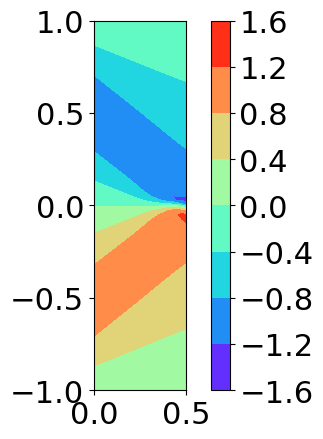

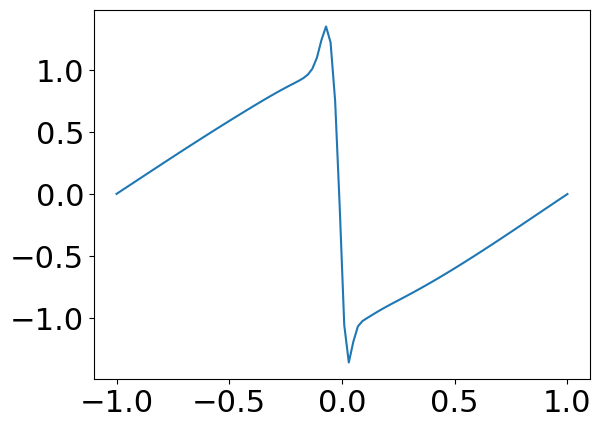

In [258]:
x = np.linspace(-1,1,100)
y = np.linspace(0,0.5,100)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

X_star = torch.cat([xx,yy,torch.ones_like(xx)*(0.001/np.pi)],axis = 1)

znn = model(X_star)

xx,yy = np.meshgrid(x, y)

U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), znn.detach().numpy().flatten(), (xx,yy), method='cubic')

print(U_pred.shape)

h = plt.contourf(y.flatten(), x.flatten(), U_pred.T,cmap='rainbow')


plt.axis('scaled')
plt.colorbar()
plt.show()
plt.plot(x,U_pred[-1,:])


In [259]:
# xy = torch.tensor(dta_set).float()
import time
time_model1 = {"fit_LAa":[],"fit_LAb_diag":[],"fit_LAb_full":[],"call_LAfull":[],"call_LAdiag":[]}
time_model2 = {"fit_LAa":[],"fit_LAb_diag":[],"fit_LAb_full":[],"call_LAfull":[],"call_LAdiag":[]}

start = time.time()

dta_set = np.hstack((samples_space(500,space),samples_param(min_param,max_param,500).reshape(-1,1)))
xy = torch.tensor(dta_set).float()

In [260]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))


x,y, param = Variable(xy[:,0].reshape(-1,1),requires_grad=True),Variable(xy[:,1].reshape(-1,1),requires_grad=True),Variable(xy[:,2].reshape(-1,1),requires_grad=True)

##############################################

f_pred = model.DE(x,y, param)
#############################################

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

df_theta_1 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_1)),1)

print(df_theta_1)

tensor([[ 0.9906,  0.2810,  0.0938,  ..., -0.1140,  0.0626,  1.0000],
        [-1.0000, -0.3430, -0.2374,  ...,  0.0912,  0.8923,  1.0000],
        [-0.8335, -0.3659, -0.0721,  ..., -0.0628,  0.7965,  1.0000],
        ...,
        [ 0.9566, -0.1227,  0.0910,  ..., -0.0301,  0.9518,  1.0000],
        [-0.9930, -0.3534, -0.1517,  ..., -0.0442,  0.8119,  1.0000],
        [ 0.9519, -0.0473,  0.0965,  ..., -0.0337,  0.9504,  1.0000]])


In [261]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

ic_x_pred = model(torch.cat([torch.ones_like(x).float()*(-1),y, param], dim=1))

h1.remove()

loss_u_ic = loss(ic_x_pred,torch.zeros_like(ic_x_pred))

df_f_2 = grad(loss_u_ic, ic_x_pred, create_graph=True)[0]

ddf_ff_2 = grad(df_f_2, ic_x_pred, torch.ones_like(df_f_1))[0]

df_theta_2 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_2)

tensor([[ 0.9909,  0.2801,  0.0909,  ..., -0.1174,  0.0018,  1.0000],
        [ 0.9882,  0.2783,  0.0840,  ..., -0.1185, -0.0132,  1.0000],
        [ 0.9997,  0.3053,  0.1728,  ..., -0.0976,  0.2006,  1.0000],
        ...,
        [ 0.9996,  0.3000,  0.1736,  ..., -0.1017,  0.1976,  1.0000],
        [ 0.9939,  0.2839,  0.1009,  ..., -0.1149,  0.0243,  1.0000],
        [ 0.9978,  0.2907,  0.1288,  ..., -0.1111,  0.0792,  1.0000]])


In [262]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

bc_pred = model(torch.cat([torch.ones_like(x).float(),y, param], dim=1))

h1.remove()

loss_u_bc = loss(bc_pred,torch.zeros_like(bc_pred))

df_f_3 = grad(loss_u_bc, bc_pred, create_graph=True)[0]

ddf_ff_3 = grad(df_f_3, bc_pred, torch.ones_like(df_f_1))[0]

df_theta_3 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_3)

tensor([[-1.0000, -0.3324, -0.2253,  ...,  0.1112,  0.9019,  1.0000],
        [-1.0000, -0.3344, -0.2343,  ...,  0.1097,  0.8975,  1.0000],
        [-1.0000, -0.3282, -0.1722,  ...,  0.0836,  0.9031,  1.0000],
        ...,
        [-1.0000, -0.3293, -0.1692,  ...,  0.0789,  0.9005,  1.0000],
        [-1.0000, -0.3308, -0.2159,  ...,  0.1115,  0.9054,  1.0000],
        [-1.0000, -0.3315, -0.1991,  ...,  0.1023,  0.9066,  1.0000]])


In [263]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

ic_pred = model(torch.cat([x,torch.zeros_like(x).float(), param], dim=1))

h1.remove()

loss_u_ic = loss(f_pred,torch.zeros_like(x)),  loss(ic_pred,(-torch.sin(torch.pi*x)))

df_f_4 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

ddf_ff_4 = grad(df_f_4, ic_pred, torch.ones_like(df_f_1))[0]

df_theta_4 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_4)),1)

print(df_theta_4)

tensor([[ 0.9995,  0.2870,  0.1777,  ..., -0.1041,  0.2876,  1.0000],
        [-0.9999, -0.3496, -0.1552,  ...,  0.0319,  0.8810,  1.0000],
        [-0.7619, -0.3632, -0.0566,  ..., -0.0653,  0.8041,  1.0000],
        ...,
        [ 0.9571, -0.1280,  0.0909,  ..., -0.0296,  0.9511,  1.0000],
        [-0.2038, -0.3173,  0.0045,  ..., -0.0302,  0.9023,  1.0000],
        [ 0.9546, -0.1323,  0.0908,  ..., -0.0310,  0.9507,  1.0000]])


In [264]:
wt,bias = model.layers[-1].weight, model.layers[-1].bias

param_MAP = torch.cat((wt,bias.reshape(1,1)),1) 

nparam = param_MAP.reshape(-1).shape

end = time.time()

time_model1["fit_LAa"].append( end- start)

print(df_theta_1.shape,df_theta_2.shape,df_theta_3.shape,df_theta_3.shape,nparam)

torch.Size([500, 31]) torch.Size([500, 31]) torch.Size([500, 31]) torch.Size([500, 31]) torch.Size([31])


In [265]:
start = time.time()


H = (xy.shape[0]/2)*(torch.sum(df_theta_1*ddf_ff_1*df_theta_1,axis=0)+ torch.sum(df_theta_2*ddf_ff_2*df_theta_2,axis=0)+\
              torch.sum(df_theta_3*ddf_ff_3*df_theta_3,axis=0)+ torch.sum(df_theta_4*ddf_ff_4*df_theta_4,axis=0))

end = time.time()

time_model1["fit_LAb_diag"].append( end- start)

print(H,H.shape)

tensor([1831.6997,  177.3317,   49.2939, 1254.6625, 1845.2849,   45.5427,
        1801.8577, 1789.4121,   26.4903, 1789.3481,  965.8060, 1823.3416,
          56.9026,  897.5483, 1284.3762,   32.6998, 1833.6682,  123.2728,
          26.0232,  427.3188,   14.4395, 1716.7255,   10.2854,   38.8599,
          68.4631,  162.2970, 1769.2988, 1076.0991,   15.4393, 1082.6130,
        2000.0002]) torch.Size([31])


In [266]:
from torch.distributions.multivariate_normal import _precision_to_scale_tril

start = time.time()

Hfull = (xy.shape[0]/2)*(torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_1, df_theta_1), ddf_ff_1),axis=0) +\
                  torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_2, df_theta_2), ddf_ff_2),axis=0)+\
                    torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_3, df_theta_3), ddf_ff_3),axis=0)+\
                        torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_4, df_theta_4), ddf_ff_4),axis=0))

end = time.time()

time_model1["fit_LAb_full"].append( end- start)

print(Hfull,Hfull.shape)

tensor([[ 1.8317e+03,  5.0455e+02,  2.8618e+02, -9.5494e+02, -1.8325e+03,
         -2.7559e+02,  1.5511e+03, -1.8052e+03, -1.9507e+02, -1.6980e+03,
         -1.1079e+03,  1.8147e+03,  3.1084e+02,  1.0069e+03, -9.7851e+02,
          5.2481e+01, -1.6745e+02,  2.4766e+02, -2.0589e+02,  8.4372e+02,
          1.1862e+02,  1.6983e+03,  8.8242e+01,  2.3952e+02,  3.4567e+02,
          4.7191e+02,  1.0077e+01,  2.4397e+02, -1.3854e+02, -3.8655e+02,
          1.0340e+02],
        [ 5.0455e+02,  1.7733e+02,  8.2304e+01, -1.6206e+02, -5.1727e+02,
         -8.6067e+01,  5.5779e+02, -5.1243e+02, -5.9248e+01, -5.4847e+02,
         -4.0684e+02,  5.2164e+02,  9.5978e+01,  2.0798e+02, -4.2502e+02,
          3.2081e+01,  1.0891e+02,  1.2161e+02, -6.4158e+01,  2.5509e+02,
          3.7026e+01,  5.2546e+02,  2.4449e+01,  7.7425e+01,  9.9404e+01,
          1.6947e+02,  1.6421e+02, -5.6293e+01, -3.7605e+01, -2.5795e+02,
         -1.3245e+02],
        [ 2.8618e+02,  8.2304e+01,  4.9294e+01, -1.3999e+02, -2.86

In [267]:
_sigma_noise=torch.tensor([1])
temperature=torch.tensor([1])

def sigma_noise():
    return _sigma_noise

def _H_factor():
    sigma2 = sigma_noise().square()
    return 1 / sigma2 / temperature

def prior_precision_diag(prior_precision,n_params):
    """Obtain the diagonal prior precision \\(p_0\\) constructed from either
    a scalar, layer-wise, or diagonal prior precision.

    Returns
    -------
    prior_precision_diag : torch.Tensor
    """
    if len(prior_precision) == 1:  # scalar
        return prior_precision * torch.ones(n_params, device=device)

    elif len(prior_precision) == n_params:  # diagonal
        return prior_precision

In [268]:
import scipy.io

data = scipy.io.loadmat('../Projects-1/Physics _Informed_NN/Pytorch/burgers_shock.mat')
y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]

Exact = np.real(data['usol']).T

(256, 1)


<Figure size 640x480 with 0 Axes>

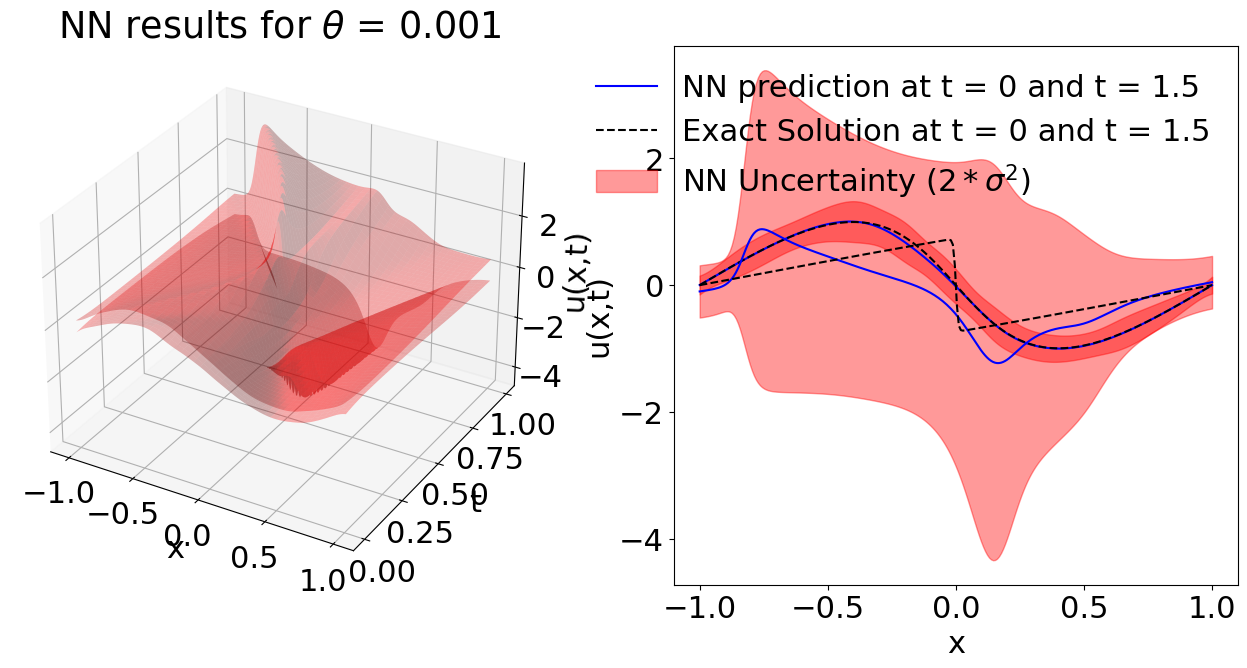

In [269]:
param_trained =  np.array([0.001])
prior_pre=torch.tensor([0.05])
prior_pre_diag = prior_precision_diag(prior_pre,nparam)

#x = np.linspace(0,1,100)
#y = np.linspace(0,1,100)

xx, yy = np.meshgrid(x, y)

# Plotting

plt.suptitle("Full Hessian Approximation",color = "red")

for n,pr in enumerate(param_trained):

    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)
################################################################################################
    
    forw_activation= {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f = model(X_star)

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull + torch.diag(prior_pre_diag)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()

################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = Exact

    z_error = np.abs(z_pred - z_exact)

    fig = plt.figure(figsize=(16, 7))

    ax = fig.add_subplot(121, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    ax.set_title(fr"NN results for $\theta$ = {pr:0.3f}")
    ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "red",label = r"NN Uncertainty ($2*\sigma^{2}$)")
    ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "red")

    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel(r'u(x,t)')


    ax = fig.add_subplot(122)
    print(x.shape)

    ax.plot(x,z_pred[10,:],color = "blue", label = "NN prediction at t = 0 and t = 1.5")
    ax.plot(x,z_exact[10,:],linestyle = "--",color = "black", label = "Exact Solution at t = 0 and t = 1.5")
    ax.fill_between(x.reshape(-1), z_pred[10,:]+2*z_pred_var[10,:],z_pred[10,:]-2*z_pred_var[10,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($2*\sigma^{2}$)")

    ax.plot(x,z_pred[-1,:],color = "blue")
    ax.fill_between(x.reshape(-1), z_pred[-1,:]+2*z_pred_var[-1,:],z_pred[-1,:]-2*z_pred_var[-1,:],alpha=0.4, color = "red")
    ax.plot(x,z_exact[-1,:],linestyle = "--",color = "black")

    ax.set_xlabel('x')
    ax.set_ylabel(r'u(x,t)')

    plt.legend(frameon = False)

In [270]:
# xy = torch.tensor(np.load('../Projects-1/Physics _Informed_NN/Models/LA_BurgEq2.npy')).float()

In [271]:
model2 = DNN(layers)
model2.load_state_dict(torch.load("../Projects-1/Physics _Informed_NN/Models/LA_BurgEq2_WD.pt"))
model2.eval()

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=3, out_features=30, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [272]:
start = time.time()

dta_set = np.hstack((samples_space(1500,space),samples_param(min_param,max_param,1500).reshape(-1,1)))
xy = torch.tensor(dta_set).float()

In [273]:
# a dict to store the activations
forw_activation2 = {}
def forw_getActivation2(name):
  # the hook signature
  def hook(model2, input, output):
    forw_activation2[name] = output.detach()
  return hook

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

x,y, param = Variable(xy[:,0].reshape(-1,1),requires_grad=True),Variable(xy[:,1].reshape(-1,1),requires_grad=True),Variable(xy[:,2].reshape(-1,1),requires_grad=True)

##############################################

f_pred = model2.DE(x,y, param)
#############################################

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1_2 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

df_theta_1_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_1_2)),1)

print(df_theta_1_2)

tensor([[-0.4538,  0.0076, -0.9999,  ...,  0.0522,  0.9557,  1.0000],
        [-0.4454,  0.0077, -1.0000,  ...,  0.0571,  0.9527,  1.0000],
        [-0.9958, -0.0445,  0.8465,  ..., -0.0193,  0.9728,  1.0000],
        ...,
        [-0.3752,  0.0012, -1.0000,  ...,  0.0543,  0.9697,  1.0000],
        [-0.9855, -0.0216,  0.9649,  ..., -0.0337,  0.9407,  1.0000],
        [-0.9816, -0.0179,  0.9537,  ..., -0.0341,  0.9276,  1.0000]])


In [274]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

ic_x_pred = model2(torch.cat([torch.ones_like(x).float()*(-1),y, param], dim=1))

h1.remove()

loss_u_ic = loss(ic_x_pred,torch.zeros_like(ic_x_pred))

df_f_2 = grad(loss_u_ic, ic_x_pred, create_graph=True)[0]

ddf_ff_2_2 = grad(df_f_2, ic_x_pred, torch.ones_like(df_f_1))[0]

df_theta_2_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_2_2)),1)

print(df_theta_2_2)

tensor([[-3.7061e-01, -1.8860e-03, -9.9998e-01,  ...,  5.3772e-02,
          9.7761e-01,  1.0000e+00],
        [-3.5998e-01, -8.6444e-04, -9.9998e-01,  ...,  5.3872e-02,
          9.6975e-01,  1.0000e+00],
        [-3.7562e-01, -1.3188e-03, -9.9998e-01,  ...,  5.3798e-02,
          9.7533e-01,  1.0000e+00],
        ...,
        [-3.7034e-01, -8.2181e-04, -9.9998e-01,  ...,  5.3697e-02,
          9.7263e-01,  1.0000e+00],
        [-3.7537e-01, -1.9644e-03, -9.9997e-01,  ...,  5.4051e-02,
          9.7647e-01,  1.0000e+00],
        [-3.7603e-01, -1.4031e-03, -9.9998e-01,  ...,  5.3765e-02,
          9.7598e-01,  1.0000e+00]])


In [275]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

bc_pred = model2(torch.cat([torch.ones_like(x).float(),y, param], dim=1))

h1.remove()

loss_u_bc = loss(bc_pred,torch.zeros_like(bc_pred))

df_f_3 = grad(loss_u_bc, bc_pred, create_graph=True)[0]

ddf_ff_3_2 = grad(df_f_3, bc_pred, torch.ones_like(df_f_3))[0]

df_theta_3_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_3_2)),1)

print(df_theta_3_2)

tensor([[-9.2407e-01,  2.1328e-03,  9.8014e-01,  ..., -3.7283e-02,
          8.3660e-01,  1.0000e+00],
        [-9.5711e-01, -3.7264e-03,  9.7690e-01,  ..., -3.4690e-02,
          7.8514e-01,  1.0000e+00],
        [-9.3910e-01,  2.6987e-04,  9.7563e-01,  ..., -3.6427e-02,
          8.2367e-01,  1.0000e+00],
        ...,
        [-9.5095e-01, -2.0634e-03,  9.6914e-01,  ..., -3.5387e-02,
          8.0749e-01,  1.0000e+00],
        [-9.3149e-01,  1.3387e-03,  9.8403e-01,  ..., -3.6720e-02,
          8.2703e-01,  1.0000e+00],
        [-9.3540e-01,  8.2090e-04,  9.7569e-01,  ..., -3.6703e-02,
          8.2828e-01,  1.0000e+00]])


In [276]:
# a dict to store the activations
forw_activation2 = {}

h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

ic_pred = model2(torch.cat([x,torch.zeros_like(x).float(), param], dim=1))

h1.remove()

loss_u_ic = loss(f_pred,torch.zeros_like(x)),  loss(ic_pred,(-torch.sin(torch.pi*x)))

df_f_4 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

ddf_ff_4_2 = grad(df_f_4, ic_pred, torch.ones_like(df_f_4))[0]

df_theta_4_2 = torch.cat((forw_activation2['layers.activation_3'],torch.ones_like(ddf_ff_4_2)),1)

print(df_theta_4_2)

tensor([[-0.5678, -0.0120, -0.3348,  ...,  0.0480,  0.8992,  1.0000],
        [-0.4945,  0.0102, -0.9997,  ...,  0.0582,  0.9242,  1.0000],
        [-0.9439, -0.0391,  0.3183,  ...,  0.0277,  0.9299,  1.0000],
        ...,
        [-0.3666,  0.0037, -1.0000,  ...,  0.0549,  0.9491,  1.0000],
        [-0.9876, -0.0495,  0.8758,  ...,  0.0069,  0.9485,  1.0000],
        [-0.9897, -0.0451,  0.8410,  ..., -0.0028,  0.9355,  1.0000]])


In [277]:
wt,bias = model2.layers[-1].weight, model2.layers[-1].bias

param_MAP_2 = torch.cat((wt,bias.reshape(1,1)),1) 

nparam2 = param_MAP_2.reshape(-1).shape

end = time.time()

time_model2["fit_LAa"].append(end- start)

print(df_theta_1_2.shape,df_theta_2_2.shape,df_theta_3_2.shape,df_theta_3_2.shape,nparam2)

torch.Size([1500, 31]) torch.Size([1500, 31]) torch.Size([1500, 31]) torch.Size([1500, 31]) torch.Size([31])


In [278]:
start = time.time()

H2 = (xy.shape[0]/2)*(torch.sum(df_theta_1_2*ddf_ff_1_2*df_theta_1_2,axis=0)+ torch.sum(df_theta_2_2*ddf_ff_2_2*df_theta_2_2,axis=0)+\
              torch.sum(df_theta_3_2*ddf_ff_3_2*df_theta_3_2,axis=0)+ torch.sum(df_theta_4_2*ddf_ff_4_2*df_theta_4_2,axis=0))
end = time.time()

time_model2["fit_LAb_diag"].append(end- start)
print(H2,H2.shape)

tensor([3.2526e+03, 1.8662e+00, 5.0243e+03, 6.2030e+00, 5.2942e+03, 1.4716e+01,
        4.7408e+01, 4.8976e+03, 4.3239e+03, 8.3200e+00, 1.0506e+02, 5.0919e+03,
        1.3232e+03, 5.0678e+03, 2.5516e-01, 2.7522e+03, 9.7031e-01, 1.4391e-02,
        2.7306e+03, 9.8765e+01, 1.6098e+01, 4.7017e+03, 6.6376e+01, 1.1125e+01,
        1.2393e+01, 2.3307e+01, 5.0264e+03, 4.3521e+00, 1.1708e+01, 4.9439e+03,
        6.0000e+03]) torch.Size([31])


In [279]:
start = time.time()

Hfull2 = (xy.shape[0]/2)*(torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_1_2, df_theta_1_2), ddf_ff_1_2),axis=0) +\
                  torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_2_2, df_theta_2_2), ddf_ff_2_2),axis=0)+\
                    torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_3_2, df_theta_3_2), ddf_ff_3_2),axis=0)+\
                        torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_4_2, df_theta_4_2), ddf_ff_4_2),axis=0))
end = time.time()

time_model2["fit_LAb_full"].append(end- start)
print(Hfull2,Hfull2.shape)

tensor([[ 3.2526e+03,  4.9196e+01, -1.2965e+03,  9.1174e-01,  3.9360e+03,
          8.0516e+00, -2.0725e+01, -3.8518e+03, -3.6591e+03,  1.3450e+01,
          3.0023e+01, -1.7541e+03, -1.6079e+03,  1.8379e+03,  1.3385e+01,
          2.8211e+03, -5.1270e+00,  2.1537e-01,  1.8183e+03,  1.0043e+01,
         -1.3566e+01, -1.1012e+03, -1.7479e+01, -1.1380e+01, -1.7686e+01,
         -1.5325e+01,  1.2802e+03, -3.8348e+00, -1.0860e+01, -3.6246e+03,
         -4.0960e+03],
        [ 4.9196e+01,  1.8662e+00, -3.5654e+01, -1.5741e-01,  5.0526e+01,
         -5.3572e-02, -1.3177e-01, -5.1336e+01, -5.1121e+01,  4.0305e-02,
          5.2014e-02, -4.7664e+01, -2.6013e+00,  4.9508e+01,  2.6354e-01,
          4.8273e+01, -3.7816e-02,  6.9333e-03,  4.7816e+01, -2.2767e-01,
         -9.2426e-02, -2.4804e+01,  3.1053e-02, -4.3237e-02, -4.6259e-02,
          1.0028e-02,  3.4052e+01, -4.9451e-02, -5.8518e-02, -4.7446e+01,
         -5.1660e+01],
        [-1.2965e+03, -3.5654e+01,  5.0243e+03,  1.6155e+02, -6.72

(256, 1)


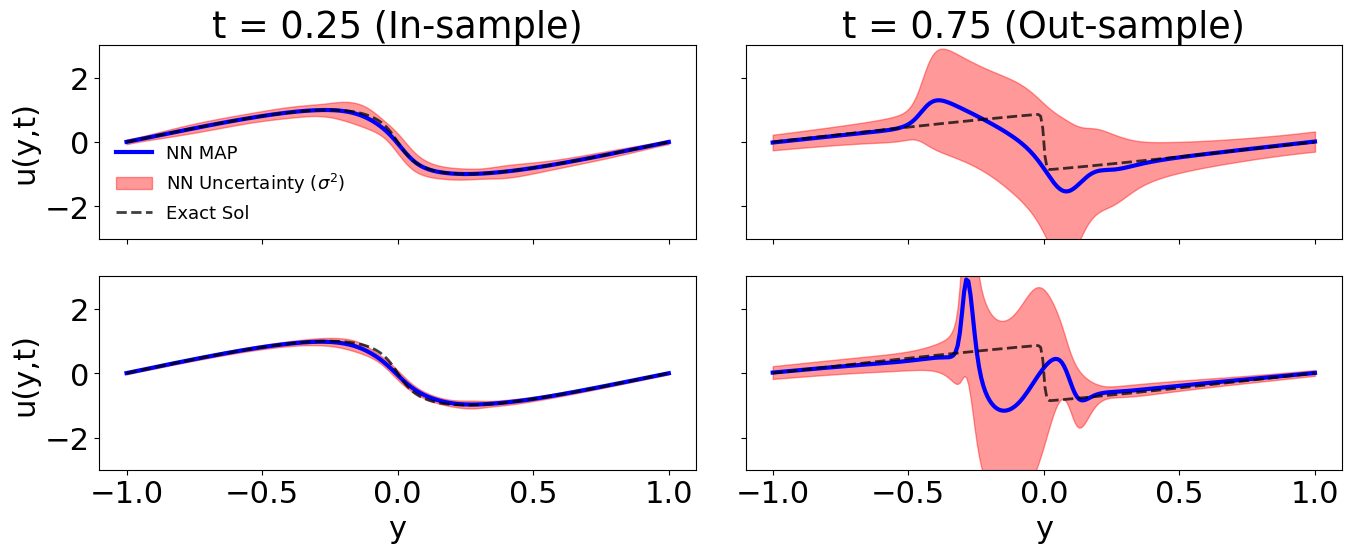

In [280]:
param_trained =  np.array([(0.01/np.pi)])
prior_pre=torch.tensor([0.0001])
prior_pre_diag = prior_precision_diag(prior_pre,nparam)

y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
print(x.shape)

xx, yy = np.meshgrid(x, y)

# Plotting

#plt.suptitle("Full Hessian Approximation",color = "red")
#fig = plt.figure(figsize=(15, 6))

for n,pr in enumerate(param_trained):

    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)
    
    start = time.time()

    forw_activation= {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f = model(X_star)

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull + torch.diag(prior_pre_diag)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()
    
    end = time.time()
    time_model1["call_LAfull"].append(end- start)

################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = Exact

    z_error = np.abs(z_pred - z_exact)


    #ax = fig.add_subplot(221, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    # ax.set_title(fr"NN trained with K-samples = 1,000",color = "red")
    # ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "red",label = r"NN Uncertainty ($2*\sigma^{2}$)")
    # ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "red")

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
        # ax.set_zlabel(r'u(x,t)')
    fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharey=True,sharex=True)
    plt.rcParams.update({'font.size': 22})

    #ax = plt.subplot(221)
    axs[0,0].set_title(fr"t = 0.25 (In-sample)",color = "black")
    axs[0,0].plot(x,z_pred[25,:],color = "blue", label = "NN MAP",linewidth=3)
    axs[0,0].fill_between(x.reshape(-1), z_pred[25,:]+z_pred_var[25,:],z_pred[25,:]-z_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[0,0].plot(x,z_exact[25,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
    #ax.set_xlabel('x')
    axs[0,0].set_ylabel(r'u(y,t)')

    axs[0,0].legend(frameon = False, prop={'size': 13},loc='lower left')

    #axs[1] = plt.subplot(222,sharey = ax)
    axs[0,1].set_title(fr"t = 0.75 (Out-sample)",color = "black")
    axs[0,1].plot(x,z_pred[75,:],color = "blue",linewidth=3)
    axs[0,1].fill_between(x.reshape(-1), z_pred[75,:]+z_pred_var[75,:],z_pred[75,:]-z_pred_var[75,:],alpha=0.4, color = "red")
    axs[0,1].plot(x,z_exact[75,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)

    #ax1.set_xlabel('x')
    #axs[0,1].set_ylabel(r'u(x,t)')
################################################################################################
    start = time.time()

    forw_activation2= {}
    h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

    f = model2(X_star)

    h1.remove()

    phi = forw_activation2['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull2 + torch.diag(prior_pre_diag)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()
    
    end = time.time()
    time_model2["call_LAfull"].append(end- start)
################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = Exact

    z_error = np.abs(z_pred - z_exact)

    #ax = fig.add_subplot(223, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    # ax.set_title(fr"NN trained with K-samples = 3,000",color = "blue")
    # ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "blue")
    # ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "blue")

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
    # ax.set_zlabel(r'u(x,t)')


    axs[1,0].plot(x,z_pred[25,:],color = "blue",linewidth=3)
    axs[1,0].fill_between(x.reshape(-1), z_pred[25,:]+z_pred_var[25,:],z_pred[25,:]-z_pred_var[25,:],alpha=0.4, color = "red")
    axs[1,0].plot(x,z_exact[25,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[1,0].set_xlabel('y')
    axs[1,0].set_ylabel(r'u(y,t)')
    axs[1,0].set_ylim(-3,3)


    axs[1,1].plot(x,z_pred[75,:],color = "blue",linewidth=3)
    axs[1,1].fill_between(x.reshape(-1), z_pred[75,:]+z_pred_var[75,:],z_pred[75,:]-z_pred_var[75,:],alpha=0.4, color = "red")
    axs[1,1].plot(x,z_exact[75,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[1,1].set_xlabel('y')
    #axs[1,1].set_ylabel(r'u(x,t)')
plt.tight_layout()

#plt.savefig("Results_FullHessian_Burgers.pdf")

<Figure size 640x480 with 0 Axes>

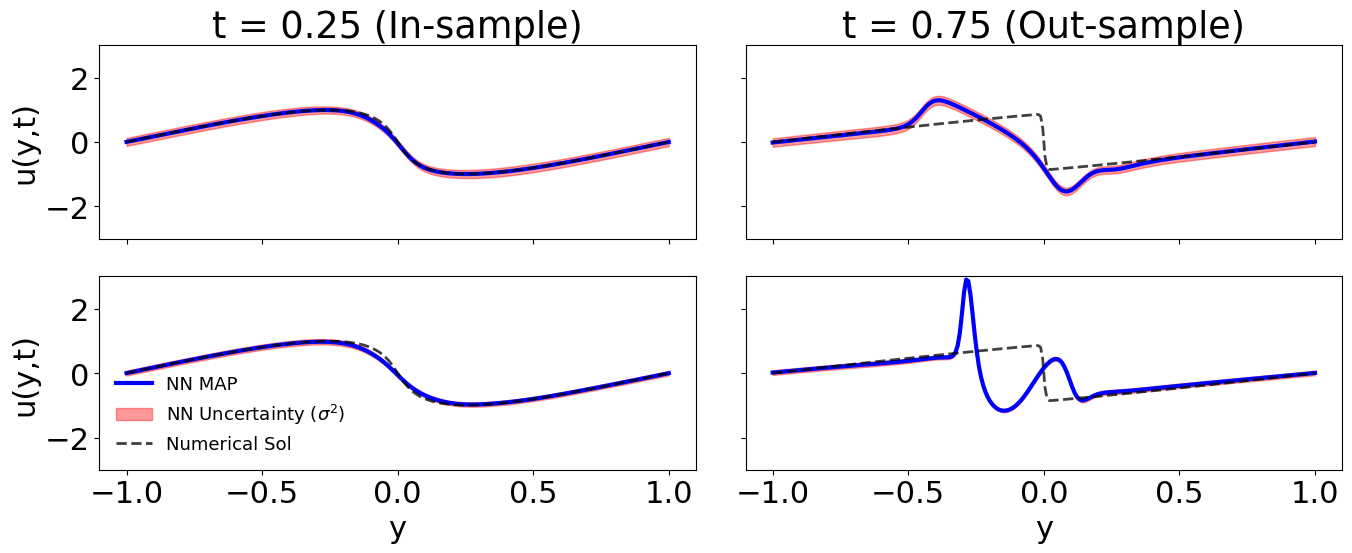

In [281]:
param_trained =  np.array([(0.01/np.pi)])
prior_pre=torch.tensor([0.0001])
prior_pre_diag = prior_precision_diag(prior_pre,nparam)

y = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]


xx, yy = np.meshgrid(x, y)

# Plotting

plt.suptitle("Full Hessian Approximation",color = "red")

for n,pr in enumerate(param_trained):

    xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()

    X_star = torch.cat([xx,yy,torch.ones_like(xx)*pr],axis = 1)
    start = time.time()

    forw_activation= {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f = model(X_star)

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * H + prior_pre_diag


    post_variance = 1 / post_presicion

    functional_var = torch.einsum('ncp,p,nkp->nck', Js, post_variance.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()
    
    end = time.time()
    time_model1["call_LAdiag"].append(end- start)
################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = Exact

    z_error = np.abs(z_pred - z_exact)

    #ax = fig.add_subplot(221, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    # ax.set_title(fr"NN trained with K-samples = 1,000",color = "red")
    # ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "red",label = r"NN Uncertainty ($2*\sigma^{2}$)")
    # ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "red")

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
    # ax.set_zlabel(r'u(x,t)')


    fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharey=True,sharex=True)
    plt.rcParams.update({'font.size': 22})

    #ax = plt.subplot(221)
    axs[0,0].set_title(fr"t = 0.25 (In-sample)",color = "black")
    axs[0,0].plot(x,z_pred[25,:],color = "blue", label = "NN MAP",linewidth=3)
    axs[0,0].fill_between(x.reshape(-1), z_pred[25,:]+z_pred_var[25,:],z_pred[25,:]-z_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[0,0].plot(x,z_exact[25,:],linestyle = "--",alpha = 0.75,color = "black", label = "Exact Sol",linewidth=2)
    #ax.set_xlabel('x')
    axs[0,0].set_ylabel(r'u(y,t)')

    #axs[1] = plt.subplot(222,sharey = ax)
    axs[0,1].set_title(fr"t = 0.75 (Out-sample)",color = "black")
    axs[0,1].plot(x,z_pred[75,:],color = "blue",linewidth=3)
    axs[0,1].fill_between(x.reshape(-1), z_pred[75,:]+z_pred_var[75,:],z_pred[75,:]-z_pred_var[75,:],alpha=0.4, color = "red")
    axs[0,1].plot(x,z_exact[75,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)

################################################################################################
    start = time.time()

    forw_activation2= {}
    h1 = model2.layers[-2].register_forward_hook(forw_getActivation2('layers.activation_3'))

    f = model2(X_star)

    h1.remove()

    phi = forw_activation2['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * H2 + prior_pre_diag


    post_variance = 1 / post_presicion

    functional_var = torch.einsum('ncp,p,nkp->nck', Js, post_variance.float(), Js)

    f_mu = f
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy()

    end = time.time()
    time_model2["call_LAdiag"].append(end- start)
################################################################################################
    xx,yy = np.meshgrid(x, y)

    z_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu.detach().numpy().flatten(), (xx,yy), method='cubic')
    z_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma.flatten(), (xx,yy), method='cubic')

    z_exact = Exact

    z_error = np.abs(z_pred - z_exact)

    #ax = fig.add_subplot(223, projection='3d')
    #axs.plot_surface(xx,yy,z_pred)
    # ax.set_title(fr"NN trained with K-samples = 3,000",color = "blue")
    # ax.plot_surface(xx,yy,z_pred + 2*z_pred_var,alpha = 0.3, color = "blue")
    # ax.plot_surface(xx,yy,z_pred - 2*z_pred_var,alpha = 0.3, color = "blue")

    # ax.set_xlabel('x')
    # ax.set_ylabel('t')
    # ax.set_zlabel(r'u(x,t)')


    axs[1,0].plot(x,z_pred[25,:],color = "blue",linewidth=3, label = "NN MAP")
    axs[1,0].fill_between(x.reshape(-1), z_pred[25,:]+z_pred_var[25,:],z_pred[25,:]-z_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[1,0].plot(x,z_exact[25,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2, label = "Numerical Sol")
    axs[1,0].set_xlabel('y')
    axs[1,0].set_ylabel(r'u(y,t)')
    axs[1,0].set_ylim(-3,3)
    axs[1,0].legend(frameon = False, prop={'size': 13},loc='lower left')


    axs[1,1].plot(x,z_pred[75,:],color = "blue",linewidth=3)
    axs[1,1].fill_between(x.reshape(-1), z_pred[75,:]+z_pred_var[75,:],z_pred[75,:]-z_pred_var[75,:],alpha=0.4, color = "red")
    axs[1,1].plot(x,z_exact[75,:],linestyle = "--",alpha = 0.75,color = "black",linewidth=2)
    axs[1,1].set_xlabel('y')
    #axs[1,1].set_ylabel(r'u(x,t)')
plt.tight_layout()

#plt.savefig("Results_DiagonalHessian_Burgers.pdf")

In [282]:
time_model1

{'fit_LAa': [0.06476283073425293],
 'fit_LAb_diag': [0.00064849853515625],
 'fit_LAb_full': [0.0017859935760498047],
 'call_LAfull': [0.004229545593261719],
 'call_LAdiag': [0.05243086814880371]}

In [284]:
print(f"Time to fit Diag LA: {time_model1['fit_LAa'][0]+time_model1['fit_LAb_diag'][0]}")
print(f"Time call Diag LA: {time_model1['call_LAdiag'][0]}")

print(f"Time to fit Full LA: {time_model1['fit_LAa'][0]+time_model1['fit_LAb_full'][0]}")
print(f"Time call Full LA: {time_model1['call_LAfull'][0]}")


Time to fit Diag LA: 0.06541132926940918
Time call Diag LA: 0.05243086814880371
Time to fit Full LA: 0.06654882431030273
Time call Full LA: 0.004229545593261719


In [283]:
time_model2

{'fit_LAa': [0.06784844398498535],
 'fit_LAb_diag': [0.0031926631927490234],
 'fit_LAb_full': [0.01919412612915039],
 'call_LAfull': [0.004503965377807617],
 'call_LAdiag': [0.003252744674682617]}

In [286]:
print(f"Mean Time to fit Diag LA: { ((time_model2['fit_LAa'][0]+time_model2['fit_LAb_diag'][0])+(time_model1['fit_LAa'][0]+time_model1['fit_LAb_diag'][0]) )/2}")
print(f"Mean Time call Diag LA: {(time_model2['call_LAdiag'][0] +time_model1['call_LAdiag'][0] )}")

print(f"Mean Time to fit Full LA: {((time_model2['fit_LAa'][0]+time_model2['fit_LAb_full'][0]) + (time_model1['fit_LAa'][0]+time_model1['fit_LAb_full'][0]))/2}")
print(f"Mean Time call Full LA: {(time_model2['call_LAfull'][0]+time_model1['call_LAfull'][0])/2}")


Mean Time to fit Diag LA: 0.06822621822357178
Mean Time call Diag LA: 0.05568361282348633
Mean Time to fit Full LA: 0.07679569721221924
Mean Time call Full LA: 0.004366755485534668
